In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [2]:
"""
goal:
1) find WSG84/BNG coords for each bus stop and bus route [done]

2) add stops to the SUMONetwork 

2.0) check how bus stop looks in sumo files [done]

in sumoconfig cars and public transport files combines like this:
...
    <input>
        <net-file value="osm.net.xml.gz"/>
        <route-files value="osm_pt.rou.xml,osm.passenger.trips.xml"/>
        <additional-files value="osm.poly.xml.gz,osm_stops.add.xml"/>
    </input>
...
osm.poly.xml.gz - just polygons for visualisation buldings, rivers, etc

so for stops we need to check file: osm_stops.add.xml
so for routes we need to check file: osm.passenger.add.xml

osm_stops.add.xml example:
...
    <busStop id="4281298915" name="Heaton Chapel" lane="314942841_0" startPos="1010.46" endPos="1210.46" friendlyPos="true" lines="NT Northern: Manchester Piccadilly =&gt; Stoke Northern: Manchester Piccadilly =&gt; Buxton"/>
...
lines is not necessary, only for visualisation, so one can skip it
<access> sub-fields are only for railway stops, skip them as well


2.1) make SUMOBusStop class and BusStopsXML class [done]

2.2) crete SUMOBusStop instances based on data downloaded [done]


2.3) check bus stops in SUMO-gui [done]

3) add routes to the SUMONetwork [in progress]
3.0) check how bus routes looks in sumo files [done]

<?xml version='1.0' encoding='UTF-8'?>
<additional xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/additional_file.xsd"> 
    <busStop id="bus_stop_0" name="bus_stop_name" lane="edge0_0" startPos="1" endPos="11" friendlyPos="true"/>
    <busStop id="bus_stop_1" lane="edge1_0" startPos="1" endPos="13" friendlyPos="true"/>
    <busStop id="bus_stop_2" lane="edge2_0" startPos="1" endPos="4.5" friendlyPos="true"/>
    <busStop id="bus_stop_3" lane="edge3_1" startPos="1" endPos="4.5" friendlyPos="true"/>
    <busStop id="bus_stop_4" lane="edge4_0" startPos="0" endPos="3.5" friendlyPos="true"/>
    <busStop id="bus_stop_1197" lane="edge1197_0" startPos="2" endPos="12" friendlyPos="true"/>


    <vType id="BUS" accel="2.6" decel="4.5" sigma="0" length="10" minGap="3" maxSpeed="70" color="1,1,0" guiShape="bus"/>

<!-- <vehicle id="0" type="BUS" depart="0" color="1,1,0">
        <route edges="2/0to2/1 2/1to1/1 1/1to1/2 1/2to0/2 0/2to0/1 0/1to0/0 0/0to1/0 1/0to2/0 2/0to2/1"/>
        <stop busStop="bus_stop_1" duration="30"/>
        <stop busStop="bus_stop_4" duration="30"/>
     </vehicle> -->

    <trip id="bus_trip_0" type="BUS" depart="0" color="1,1,0" from="edge1" to="edge1197">
       <stop busStop="bus_stop_1" duration="30"/>
       <stop busStop="bus_stop_1197" duration="30"/>
       <stop busStop="bus_stop_1" duration="30"/>
    </trip>
</additional>


3.1) make SUMOBusRoute class and add it to BusStopsXML class [in progress]
- one trip for each route in bus_route_gdf
- try find closest path from edges: 

3.2) check bus routes in SUMO-gui [in progress]

"""
pass

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

In [5]:
bus_routes_gdf = gpd.read_file('gmdata.nosync/BusRouteMapData/KML-format/OpenData_BusRoutes.KML')
bus_routes_gdf = bus_routes_gdf.to_crs(27700)
# bus_routes_gdf['description'].iloc[0]

In [6]:
bus_stops_gdf = gpd.read_file('gmdata.nosync/TfGMStoppingPoints.csv')
bus_stops_gdf = bus_stops_gdf[bus_stops_gdf['Status'] == 'act']

In [7]:
# test_gdf = gpd.GeoDataFrame(geometry=list(bus_routes_gdf.iloc[-1].geometry.geoms))
# colors = ['red' if i % 2 == 1 else 'blue' for i in range(len(test_gdf))]
# test_gdf.plot(colors=colors)

In [8]:
bus_routes_gdf

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,100_C_I_1_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,MULTILINESTRING Z ((376350.869 396997.864 0.00...
1,100_C_I_1_A,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,MULTILINESTRING Z ((376627.474 396933.412 0.00...
2,100_C_I_3_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,MULTILINESTRING Z ((376350.869 396997.864 0.00...
3,100_C_I_3_A,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,MULTILINESTRING Z ((376627.474 396933.412 0.00...
4,100_C_I_4_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,MULTILINESTRING Z ((376350.869 396997.864 0.00...
...,...,...,...,...,...,...,...,...,...,...,...,...
2843,X5__O_1_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,"LINESTRING Z (376957.747 387897.489 0.000, 376..."
2844,X5__O_3_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,"LINESTRING Z (376957.747 387897.489 0.000, 376..."
2845,X92__I_1_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,"LINESTRING Z (392557.319 386366.317 0.000, 392..."
2846,Y77__I_1_,"<br><br><br>\n <table border=""1"" padding=""0...",NaT,NaT,NaT,clampToGround,1,1,1,NaN,NaN,"LINESTRING Z (394440.813 396921.176 0.000, 394..."


In [9]:
bus_stops_gdf

,AtcoCode,NaptanCode,PlateCode,CleardownCode,CommonName,CommonNameLang,ShortCommonName,ShortCommonNameLang,Landmark,LandmarkLang,...,DefaultWaitTime,Notes,NotesLang,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status,geometry
1,1800SBT0641,,,,High Street,,,,,,...,,,,83,2004-09-14T00:00:00,2019-07-31T14:34:30,1,rev,act,None
2,1800SBT0351,,,,Peter Street,,,,,,...,,,,83,2004-09-14T00:00:00,2019-07-31T14:47:41,1,rev,act,None
3,1800SG44991,MANJMGMW,,,A34 Bridge,,A34 Bridge,,HOUSE 61,,...,,INDICATOR AMENDED,,83,2014-02-17T00:00:00,2014-02-17T00:00:00,1,rev,act,None
20,1800ED02491,MANAJWMG,,,A627M,,A627M,,MOTORWAY BRIDGE,,...,,INDICATOR AMENDED,,83,2010-04-15T00:00:00,2010-04-15T00:00:00,1,rev,act,None
21,1800ED02481,MANAJWMD,,,A627M,,A627M,,MOTORWAY BRIDGE,,...,,INDICATOR AMENDED,,83,2010-04-15T00:00:00,2010-04-15T00:00:00,1,rev,act,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21098,1800WKH3551,,,,York Street,,,,,,...,,,,83,2007-11-01T00:00:00,2019-04-25T16:29:20,3,rev,act,None
21102,1800NE16201,MANDWTDG,,,Yorkshire St,,Yorkshire St,,BANK,,...,,STOP LOCATION AMENDED,,83,2015-04-28T00:00:00,2015-04-28T00:00:00,1,rev,act,None
21103,1800NB40971,MANDJWGM,,,Youth Club,,Youth Club,,GARAGES,,...,,INDICATOR AMENDED,,83,2010-04-20T00:00:00,2010-04-20T00:00:00,1,rev,act,None
21104,1800NB40961,MANDJWGJ,,,Youth Club,,Youth Club,,HOUSE 208,,...,,,,83,2007-11-01T00:00:00,2007-11-01T00:00:00,0,new,act,None


In [10]:
bus_top_locations = gpd.points_from_xy(bus_stops_gdf['Easting'], bus_stops_gdf['Northing'])

In [11]:
bus_stops_gdf.set_geometry(bus_top_locations, inplace=True)
bus_stops_gdf.crs = 27700

In [12]:
from bim.sumo.network import SUMOBusStop, BusStopId, BusLaneId, SUMOCoordinate, EdgeId, SUMONetwork

In [13]:
DEFAULT_BUS_STOP_WIDTH = 10

In [14]:
stockport_net = SUMONetwork.parse_file('gmdata.nosync/gm_osm_fixed_nl_ms_base_model/gm_osm_fixed_nl_ms_base_model.json')

In [16]:
edges_df = stockport_net.make_edges_df()

In [17]:
bus_stop_row = bus_stops_gdf.iloc[314]
location = SUMOCoordinate(x=bus_stop_row.Easting, y=bus_stop_row.Northing)

In [18]:
edges_sindex = edges_df.sindex

In [19]:
indices, distances = edges_sindex.nearest(location.to_point(), return_distance=True)
edge_index = indices[1, :][0]
distance = distances[0]

In [20]:
def find_edge(edges_df, edges_sindex, location: SUMOCoordinate, max_distance=20):
    point = location.to_point()
    indices, distances = edges_sindex.nearest(point, return_distance=True)
    edge_index = indices[1, :][0]
    distance = distances[0]
    if distance > max_distance:
        return None
    return edge_index    

In [21]:
def make_bus_stop(edges_df, edges_sindex, bus_stop_row, max_distance=20, default_lane_num=0):
    location = SUMOCoordinate(x=bus_stop_row.Easting, y=bus_stop_row.Northing)
    edge_index = find_edge(edges_df, edges_sindex, location, max_distance=max_distance)
    if edge_index is None:
        atco_code = bus_stop_row['AtcoCode']
#         print(f'drop bus stop {atco_code}: too distant from edges')
        return None
    
    edge = edges_df.iloc[edge_index]
    point = location.to_point()
    edge_position = edge['shape'].project(point)
    startPos = max(0, edge_position - DEFAULT_BUS_STOP_WIDTH / 2)
    endPos = startPos + DEFAULT_BUS_STOP_WIDTH
    
    bus_lane_id = BusLaneId.make(EdgeId(id=edge.edge_id), default_lane_num)

    sumo_bus_stop = SUMOBusStop(
        bus_stop_id=BusStopId(id=bus_stop_row['AtcoCode']),
        name=bus_stop_row['AtcoCode'],
        lane=bus_lane_id,
        startPos=startPos,
        endPos=endPos,
        location=location
    )
    return sumo_bus_stop

In [22]:
from shapely import geometry

In [23]:
net_bounding_box = geometry.box(*edges_df.geometry.total_bounds)

In [24]:
def location_within_bbox(net_bounding_box):
    def f(bus_stop_row):
        location = SUMOCoordinate(x=bus_stop_row.Easting, y=bus_stop_row.Northing)
        return location.to_point().within(net_bounding_box)
    return f
        
bus_stops_stockport_gdf = bus_stops_gdf[bus_stops_gdf.apply(location_within_bbox(net_bounding_box), axis=1)].copy()

In [25]:
len(bus_stops_stockport_gdf)

14810

In [26]:
set(bus_stops_stockport_gdf['Status'])

{'act'}

In [27]:
bus_stops_list = []
for i in range(len(bus_stops_stockport_gdf)):
    bus_stop_row = bus_stops_stockport_gdf.iloc[i]
    bus_stop = make_bus_stop(edges_df, edges_sindex, bus_stop_row, max_distance=10)
    if bus_stop is not None:
        bus_stops_list.append(bus_stop)

/opt/homebrew/anaconda3/envs/data-science-algorithms/lib/python3.8/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [28]:
len(bus_stops_list), len(bus_stops_stockport_gdf)

(13867, 14810)

In [ ]:
# bus_stops_list

In [29]:
stockport_net.bus_stops = bus_stops_list

In [30]:
stockport_net.dump_bus_stops()

In [31]:
stockport_net.save()

In [32]:
stockport_net.generate_net_file()

Success.


### Visualisations

In [34]:
missed_road = "LINESTRING (388131.1272123425 390207.0855407809, 388417.189682905 390257.0793439721, 388482.4722528178 390268.9338443803, 388556.2856914678 390281.7251754118, 388626.9417458369 390294.7812103098, 388696.2902786352 390314.394371502, 388762.9727828409 390336.8853234947, 388779.8218646584 390344.2099809583, 388819.240560654 390357.6665032451, 388870.5381116128 390376.7357151407, 388920.9438951099 390398.3775821254)"

In [33]:
missed_road2 = 'LINESTRING(-2.1800047 53.4085587,-2.1757034 53.4090145,-2.1747218 53.4091225,-2.1736119 53.4092391,-2.1725495 53.409358,-2.171507 53.4095358,-2.1705047 53.4097394,-2.1702515 53.4098056,-2.169659 53.4099274,-2.168888 53.4100999,-2.1681305 53.4102955)'

In [14]:
from shapely import wkt

In [19]:
import geopandas as gpd

In [26]:
import matplotlib.pyplot as plt

In [31]:
edges_df

,edge_id,from_id,to_id,shape,priority,num_lanes,max_speed,length,lsoa_code
0,edge0,node0,node1231,"LINESTRING (388277.016 390809.334, 388290.394 ...",2,2,50,17.258163,E01005861
1,edge1,node2,node3,"LINESTRING (388479.601 389977.526, 388488.998 ...",2,2,50,70.271998,E01005817
2,edge2,node4,node5,"LINESTRING (388265.339 390855.021, 388301.373 ...",2,2,50,108.136289,E01005861
3,edge3,node6,node7,"LINESTRING (389521.329 390765.061, 389509.555 ...",2,2,50,76.281000,E01005918
4,edge4,node8,node9,"LINESTRING (388577.755 390317.276, 388586.271 ...",2,2,50,204.324379,E01005861
...,...,...,...,...,...,...,...,...,...
2410,edge2410,node122,node124,"LINESTRING (389690.640 390510.628, 389646.612 ...",2,2,50,47.194235,E01005758
2411,edge2411,node115,node114,"LINESTRING (389526.152 390727.847, 389523.507 ...",2,2,50,18.342991,E01005918
2412,edge2412,node77,node401,"LINESTRING (389765.215 390269.612, 389767.291 ...",2,2,50,106.414977,E01005758
2413,edge2413,node68,node1807,"LINESTRING (390154.013 391021.719, 390149.159 ...",2,2,50,21.453957,E01005758


In [184]:
bus_stops_stockport_gdf['location'] = bus_stops_stockport_gdf.apply(lambda x:
    SUMOCoordinate(x=x.Easting, y=x.Northing).to_point(), 
    axis=1
)

In [185]:
# bus_stops_stockport_gdf.set_geometry(bus_stops_stockport_gdf['location'], inplace=True)
# bus_stops_stockport_gdf = bus_stops_stockport_gdf.set_crs(27700)

<Axes: >

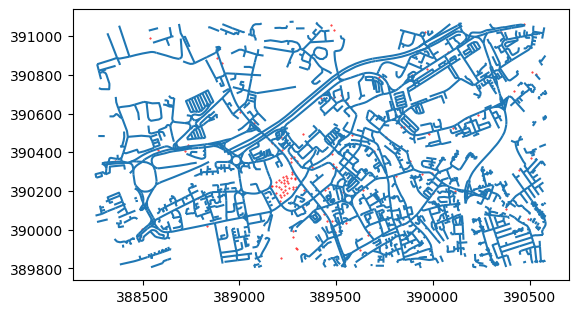

In [250]:
fig, ax = plt.subplots()
edges_df.plot(ax=ax)
# gpd.GeoDataFrame(geometry=[wkt.loads(missed_road)]).plot(ax=ax, color='red')
# gdf_missed = gpd.GeoDataFrame(geometry=[wkt.loads(missed_road2)])
# gdf_missed.set_crs(4326,inplace=True)
# gdf_missed = gdf_missed.to_crs(27700)
# gdf_missed.plot(ax=ax, color='red')

bus_stops_stockport_gdf.plot(ax=ax, markersize=0.2, color='red')

In [20]:
len(set(bus_stops_gdf['AtcoCode'])) == len(bus_stops_gdf['AtcoCode']) # codes are unique

True

In [50]:
len(bus_routes_gdf), len(bus_stops_gdf)

(2848, 21106)

<Axes: >

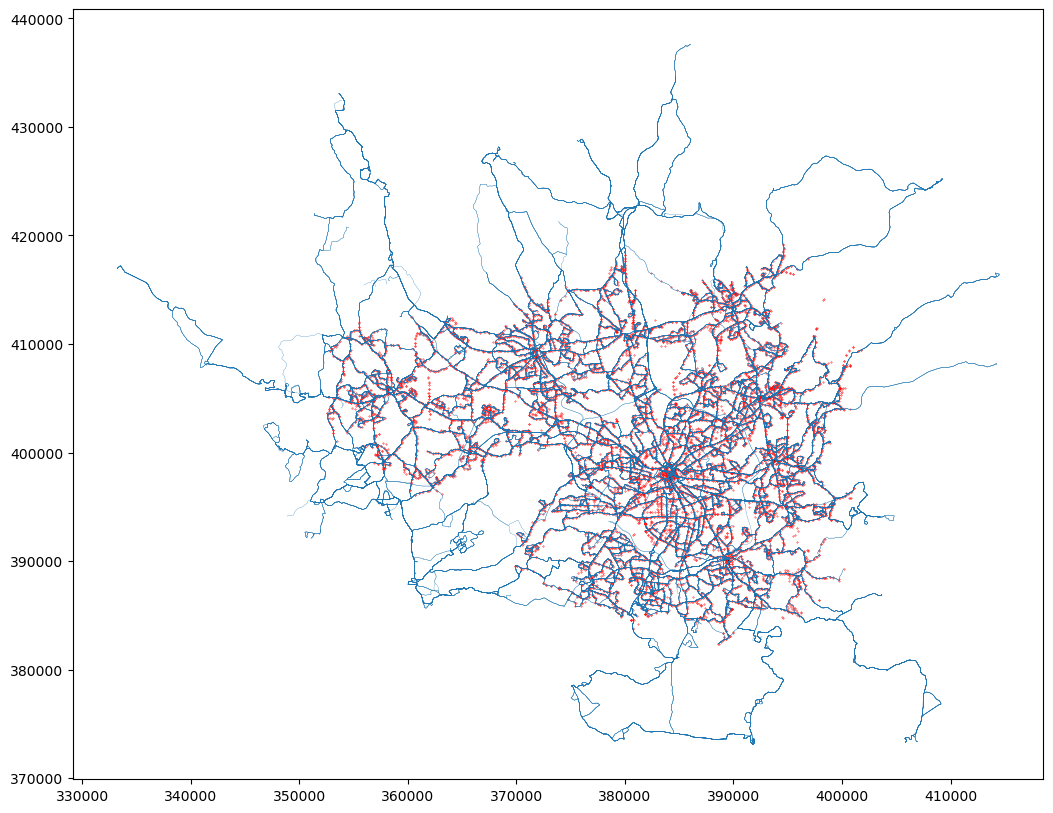

In [251]:
fig, ax = plt.subplots(figsize=(15,10))
bus_routes_gdf.plot(ax=ax, linewidth=0.2)
bus_stops_gdf.plot(ax=ax, markersize=0.1, color='red')

### Test SUMO net coordinates to WSG84 conversion

In [4]:
import sumolib
net_path = '/opt/homebrew/Cellar/sumo/1.18.0/share/sumo/tools/2023-08-26-12-04-35/osm.net.xml'
net = sumolib.net.readNet(net_path)

In [5]:
lon, lat = net.convertXY2LonLat(553746.08, 5916516.51, True)
lon, lat

(-2.191735466640028, 53.394997212399225)